In [1]:
import os
import shutil
import importlib
import copy
import glob
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import torch
import torchaudio

import phaselocknet_model
import util

importlib.reload(phaselocknet_model)
importlib.reload(util)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [2]:
regex_filenames = "/media/marmoset/data/code_package/phaselock/localization/bandwidth_dependency_stim.hdf5"
sr = 50000 if "localization" in regex_filenames else 20000
num_steps_per_display = 10
dataset = util.HDF5Dataset(regex_filenames)

In [3]:
len(dataset)

55500

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm  # progress bar
# --- config ---
skip_like = {'signal'}     # avoid large arrays
outfile_csv = "stimuli_all_para.csv"         # output file name
# --------------

def to_scalar(x):
    # Convert numpy scalars / 0-d arrays to Python scalars
    if isinstance(x, (np.generic,)):
        return x.item()
    if isinstance(x, np.ndarray) and x.shape == ():
        return x.item()
    return x

# Determine which keys to keep (prefer dataset.keys attribute if present)
if hasattr(dataset, "keys") and isinstance(dataset.keys, (list, tuple)):
    candidate_keys = [k for k in dataset.keys if k not in skip_like]
else:
    probe = dataset[0]
    candidate_keys = [k for k in probe.keys() if k not in skip_like]

rows = []
# n = len(dataset)
for i in tqdm(range(len(dataset))):
# for i in range(n):
    sample = dataset[i]  # dict per sample
    row = {}
    for k in candidate_keys:
        v = sample[k]
        # coerce simple arrays/scalars to python scalars
        try:
            if isinstance(v, np.ndarray):
                if v.ndim == 0:
                    row[k] = v.item()
                elif v.size == 1:
                    row[k] = v.reshape(()).item()
                else:
                    # if accidental vector, store a short repr
                    row[k] = str(v.shape)
            else:
                row[k] = to_scalar(v)
        except Exception:
            row[k] = str(v)  # last resort

    rows.append(row)

df = pd.DataFrame(rows)

# Make sure SNR is numeric (keeps inf as np.inf; unparsable -> NaN)
if 'snr' in df.columns:
    df['snr'] = pd.to_numeric(df['snr'], errors='coerce')

# Optional: stable sort for readability
# for key in ['segment_id', 'index', 'foreground_index_brir']:
#     if key in df.columns:
#         df = df.sort_values(by=key, kind='mergesort')
#         break

# Save
# df.to_csv(outfile_csv, index=False)
# print(f"Saved {len(df):,} rows to {outfile_csv}")

# (Optional) also save Parquet (smaller, faster)
# df.to_parquet("room0_para.parquet", index=False)


100%|████████████████████████████████████| 55500/55500 [01:44<00:00, 532.85it/s]


In [16]:
dataset[0]

{'bandwidth': 0.0,
 'cutoff_high': 210.22410381342863,
 'cutoff_low': 210.22410381342863,
 'dbspl': 53.01030010587388,
 'f': 210.22410381342863,
 'f_ref': 250,
 'foreground_azimuth': 0,
 'foreground_elevation': 0,
 'index': 0,
 'index_brir': 4,
 'index_room': 0,
 'signal': array([[ 1.1623882e-09,  1.1623882e-09],
        [ 1.9572755e-10,  1.9572755e-10],
        [-8.8618374e-10, -8.8618374e-10],
        ...,
        [-2.4909257e-09, -2.4909257e-09],
        [-1.8424274e-09, -1.8424274e-09],
        [-1.5502876e-09, -1.5502876e-09]], dtype=float32),
 'sr': 44100}

In [11]:
df["foreground_azimuth"].value_counts()

foreground_azimuth
0      1500
5      1500
10     1500
15     1500
20     1500
25     1500
30     1500
35     1500
40     1500
45     1500
50     1500
55     1500
60     1500
65     1500
70     1500
75     1500
80     1500
85     1500
90     1500
270    1500
275    1500
280    1500
285    1500
290    1500
295    1500
300    1500
305    1500
310    1500
315    1500
320    1500
325    1500
330    1500
335    1500
340    1500
345    1500
350    1500
355    1500
Name: count, dtype: int64

In [8]:
df["index_room"].value_counts()

index_room
0    3760
1    3760
2    3760
3    3760
4    3760
Name: count, dtype: int64

In [6]:
np.unique(df["f_ref"])

array([ 250,  500, 1000, 2000, 4000])

In [14]:
np.unique(df["bandwidth"])

array([0.        , 0.05      , 0.1       , 0.125     , 0.16666667,
       0.2       , 0.25      , 0.33333333, 0.5       , 1.        ,
       1.5       , 2.        ])

In [8]:
np.unique(df["f"]).shape

(125,)

In [7]:
np.unique(df["f"])

array([ 210.22410381,  213.28188382,  216.38414025,  219.53152005,
        222.72467954,  225.9642846 ,  229.2510108 ,  232.58554354,
        235.96857817,  239.40082017,  242.88298529,  246.41579966,
        250.        ,  253.63633373,  257.32555916,  261.06844561,
        264.86577359,  268.71833498,  272.62693317,  276.59238322,
        280.61551208,  284.69715869,  288.83817422,  293.0394222 ,
        297.30177875,  420.44820763,  426.56376763,  432.7682805 ,
        439.06304009,  445.44935907,  451.9285692 ,  458.5020216 ,
        465.17108708,  471.93715634,  478.80164035,  485.76597058,
        492.83159932,  500.        ,  507.27266747,  514.65111832,
        522.13689121,  529.73154718,  537.43666996,  545.25386633,
        553.18476644,  561.23102415,  569.39431738,  577.67634844,
        586.07884441,  594.6035575 ,  840.89641525,  853.12753526,
        865.53656101,  878.12608019,  890.89871814,  903.85713839,
        917.0040432 ,  930.34217415,  943.87431268,  957.60328

In [12]:
np.unique(df["foreground_azimuth"]).shape

(37,)

In [15]:
np.unique(df["index"])

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124])

In [5]:
df

,bandwidth,cutoff_high,cutoff_low,dbspl,f,f_ref,foreground_azimuth,foreground_elevation,index,index_brir,index_room,sr
0,0.000000,210.224104,210.224104,53.0103,210.224104,250,0,0,0,4,0,44100
1,0.050000,213.898756,206.612580,53.0103,210.224104,250,0,0,0,4,0,44100
2,0.100000,217.637641,203.063099,53.0103,210.224104,250,0,0,0,4,0,44100
3,0.125000,219.531520,201.311291,53.0103,210.224104,250,0,0,0,4,0,44100
4,0.166667,222.724680,198.425131,53.0103,210.224104,250,0,0,0,4,0,44100
...,...,...,...,...,...,...,...,...,...,...,...,...
55495,0.333333,5339.359417,4237.852377,53.0103,4756.828460,4000,355,0,124,785,0,44100
55496,0.500000,5656.854249,4000.000000,53.0103,4756.828460,4000,355,0,124,785,0,44100
55497,1.000000,6727.171322,3363.585661,53.0103,4756.828460,4000,355,0,124,785,0,44100
55498,1.500000,8000.000000,2828.427125,53.0103,4756.828460,4000,355,0,124,785,0,44100


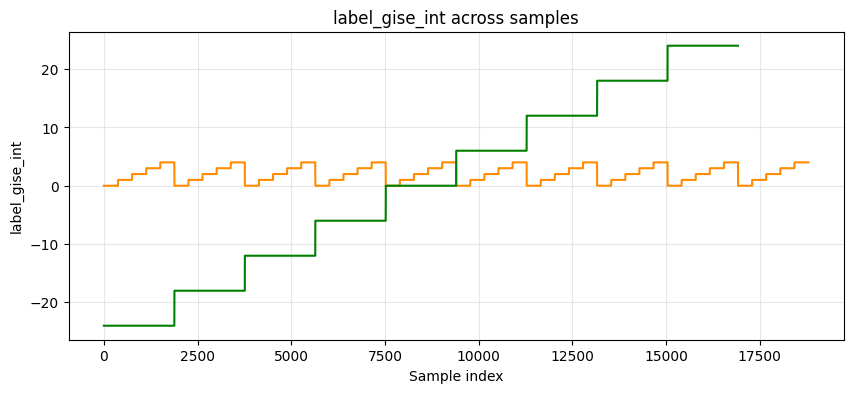

In [11]:
# df["index"].plot(figsize=(10, 4), color='pink')
df["index_room"].plot(figsize=(10, 4), color='darkorange')
df["snr"].plot(figsize=(10, 4), color='green')
plt.xlabel("Sample index")
plt.ylabel("label_gise_int")
plt.title("label_gise_int across samples")
plt.grid(alpha=0.3)
plt.show()

In [76]:
# example_id = 17125 ## 'label_word_int': 444, 'index_room': 0, 'snr': inf >>> -376, used in paper
# example_id = 17134 ## 'label_word_int': 460, 'index_room': 0, 'snr': inf

# example_id = 17501 ## 'label_word_int': 444, 'index_room': 1, 'snr': inf >>> anechoic
# example_id = 17505 ## 'label_word_int': 450, 'index_room': 1, 'snr': inf
example_id = 17510 ## 'label_word_int': 460, 'index_room': 1, 'snr': inf

# example_id = 18629 ## 'label_word_int': 444, 'index_room': 4, 'snr': inf >>> +376*3, high reverb
# example_id = 18633 ## 'label_word_int': 450, 'index_room': 4, 'snr': inf
# example_id = 18638 ## 'label_word_int': 460, 'index_room': 4, 'snr': inf 

dataset[example_id]

{'foreground_azim': 60.0,
 'foreground_dist': 2.0,
 'foreground_elev': 0.0,
 'index': 214,
 'index_brir': 12,
 'index_room': 1,
 'label_speaker_int': 421,
 'label_word_int': 460,
 'signal': array([[-7.8797210e-03, -1.8098288e-03],
        [-8.8148015e-03, -1.8072414e-03],
        [-1.1025018e-02, -1.9082298e-03],
        ...,
        [ 1.6749104e-03,  8.1582577e-05],
        [ 4.9782698e-03, -6.7180785e-04],
        [ 3.7296161e-03, -1.4587351e-03]], dtype=float32),
 'snr': inf,
 'sr': 44100}

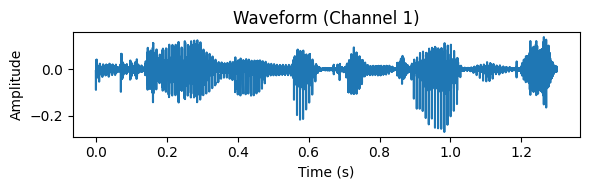

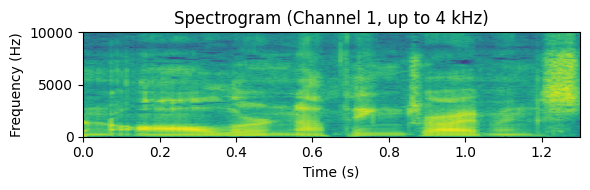

In [77]:
speech2C = dataset[example_id]['signal']

import torchaudio.transforms as T
from IPython.display import Audio

# Given:
# speech2C: numpy array of shape (57330, 2)
sr = 44100

# ---- 1. Extract first channel ----
wave_ch1 = speech2C[:,0].astype(np.float32)         # (T,)
t = np.arange(len(wave_ch1)) / sr

# ---- 2. Plot waveform (first channel) ----
plt.figure(figsize=(6, 2))
plt.plot(t, wave_ch1)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform (Channel 1)")
plt.tight_layout()
plt.show()

# ---- 3. Compute spectrogram with torchaudio (first channel) ----
# torchaudio expects shape (channels, time)
wave_ch1_tensor = torch.from_numpy(wave_ch1).unsqueeze(0)   # (1, T)

N_FFT = 1024
WIN_LENGTH = 1024
HOP_LENGTH = 256
CENTER = True

spec_tf = T.Spectrogram(
    n_fft=N_FFT,
    win_length=WIN_LENGTH,
    hop_length=HOP_LENGTH,
    power=2.0,
    center=CENTER,
    window_fn=torch.hann_window
)

spec = spec_tf(wave_ch1_tensor)          # (1, freq_bins, time_frames)
spec_db = 10 * torch.log10(spec + 1e-10) # to dB for nicer visualization

# ---- 4. Plot spectrogram ----
max_freq = 10000  # Hz
plt.figure(figsize=(6, 2))
plt.imshow(
    spec_db[0].numpy(),
    origin="lower",
    aspect="auto",
    extent=[0,
            spec_db.shape[-1] * HOP_LENGTH / sr,
            0,
            sr / 2]
)
plt.ylim(0, max_freq)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Spectrogram (Channel 1, up to 4 kHz)")
# plt.colorbar(label="Power (dB)")
plt.tight_layout()
plt.show()
# ---- 5. Play audio (first channel) ----
Audio(wave_ch1, rate=sr)
